In [1]:
import numpy as np
import pandas as pd
import volpriceinference as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from scipy import special

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
vl.__version__

'0.0.28-py37_0'

In [5]:
kharpov = True

In [6]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.01,
               'log_scale': np.log(252 * 1.564e-5),
                'logit_rho': special.logit(.8)
                }
    
    true_params['log_both'] = np.log(0.6475) + true_params['log_scale']
                
else:

#     Daily
     true_params ={'log_both': -4.45,
                   'log_scale': -3.48,
                   'logit_rho': 1.21,
                   'phi': -0.01,
                    'pi': -22.7, 
                   'theta': 0.28}
#     Weekly
#     true_params = {'log_both': -0.2768983372209973 + 0.805773558068805,
#                    'log_scale': 0.805773558068805,
#                    'rho': 0.6097218157104826,
#                    'phi': -0.8999999994952989,
#                    # Here I use the daily value.
#                    'pi': -.01,
#                    'theta': 2.6348432313374923}
    
time_dim = 2_000
sim_dim = 250
innov_dim = 250

In [7]:
bounds = {'pi': {'max': 0, 'min':-25, 'dim':32}, 'phi': {'max': 0, 'min':-.5, 'dim':4}, 
          'theta': {'max':2.5, 'min': 0, 'dim':12}}

In [8]:
total_true_params = true_params.copy()
total_true_params['psi'] = vl.compute_psi(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                          theta=true_params['theta'])
total_true_params['beta'] = vl.compute_beta(logit_rho=true_params['logit_rho'], 
                                            log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'])
total_true_params['gamma'] = vl.compute_gamma(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'], log_both=true_params['log_both'])
total_true_params['zeta'] = 1 - true_params['phi']**2                                           

In [9]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': 1.155240016994922,
 'beta': 0.09722424544370156,
 'gamma': 0.000298574376639809,
 'zeta': 0.9999}

In [10]:
vl.compute_moments(psi=total_true_params['psi'], log_scale=true_params['log_scale'],
                   log_both=true_params['log_both'], logit_rho=true_params['logit_rho'],
                   pi=true_params['pi'], phi=true_params['phi'], theta=true_params['theta'])

{'return_mean': 0.016279885604144832,
 'return_var': 0.013096576986779667,
 'vol_mean': 0.012759894000000006,
 'vol_var': 0.0002514515751216002}

In [11]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [12]:
data.describe()

,vol,rtn
count,2000.000000,2000.000000
mean,0.013204,0.018663
std,0.014986,0.122042
min,0.000010,-0.852953
25%,0.002356,-0.037798
50%,0.007728,0.007293
75%,0.018930,0.071543
max,0.097052,0.877313


In [13]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': 1.155240016994922,
 'beta': 0.09722424544370156,
 'gamma': 0.000298574376639809,
 'zeta': 0.9999}

In [14]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [15]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': 1.155240016994922,
 'beta': 0.09722424544370156,
 'gamma': 0.000298574376639809,
 'zeta': 0.9999}

## We start by examining the distributions of simulated data

In [16]:
data.corr()

,vol,rtn
vol,1.000000,0.161395
rtn,0.161395,1.000000


In [17]:
data.head()

,vol,rtn
2000-01-01,0.014894,-0.074418
2000-01-02,0.006451,0.004542
2000-01-03,0.007764,0.099558
2000-01-04,0.023445,0.035688
2000-01-05,0.017112,0.020703


In [18]:
data.var()

vol    0.000225
rtn    0.014894
dtype: float64

In [19]:
vl.compute_vol_gmm(data.vol)

({'log_both': -5.926239294053325,
  'log_scale': -5.558178821997083,
  'logit_rho': 1.3610382149874154},
            log_both  log_scale  logit_rho
 log_both   0.005357   0.001133  -0.005412
 log_scale  0.001133   0.001758  -0.000750
 logit_rho -0.005412  -0.000750   0.014777)

In [20]:
omega, omega_cov = vl.estimate_params(data)

In [21]:
total_est, total_cov = vl.estimate_params_strong_id(data, bounds=bounds)

In [22]:
omega

{'gamma': 0.0009014863664124776,
 'beta': 0.07192678228039884,
 'psi': 1.2768046680050529,
 'zeta': 1.0590414512328532,
 'log_both': -5.926239294053325,
 'log_scale': -5.558178821997083,
 'logit_rho': 1.3610382149874154}

In [23]:
omega_cov

,beta,gamma,log_both,log_scale,logit_rho,psi,zeta
beta,0.014643,-3.925791e-05,0.000000,0.000000,0.000000,-0.011675,0.000000
gamma,-0.000039,3.783454e-07,0.000000,0.000000,0.000000,0.000011,0.000000
log_both,0.000000,0.000000e+00,0.005357,0.001133,-0.005412,0.000000,0.000000
log_scale,0.000000,0.000000e+00,0.001133,0.001758,-0.000750,0.000000,0.000000
logit_rho,0.000000,0.000000e+00,-0.005412,-0.000750,0.014777,0.000000,0.000000
psi,-0.011675,1.061844e-05,0.000000,0.000000,0.000000,0.051060,0.000000
zeta,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.001151


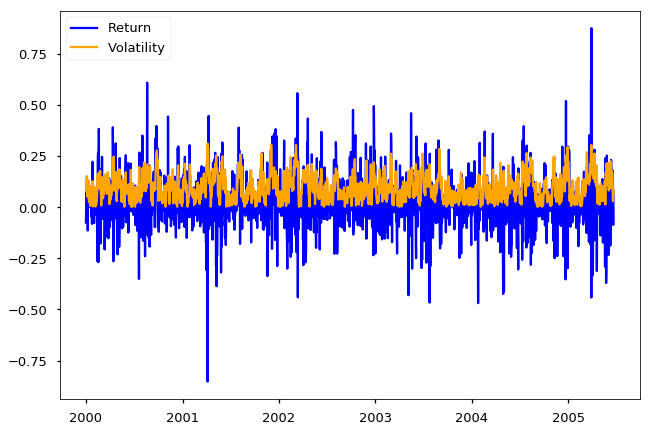

In [24]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [25]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.003748,0.001128
rtn,0.001128,0.014894


In [26]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': 1.155240016994922,
 'beta': 0.09722424544370156,
 'gamma': 0.000298574376639809,
 'zeta': 0.9999}

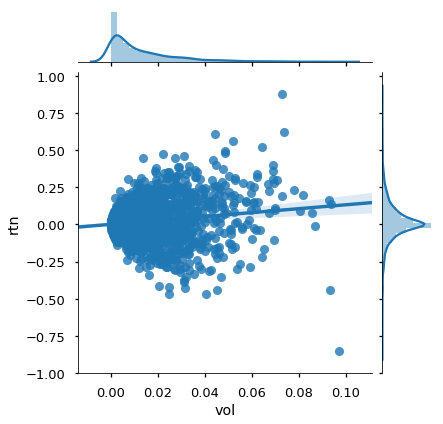

In [27]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [28]:
data.describe()

,vol,rtn
count,2000.000000,2000.000000
mean,0.013204,0.018663
std,0.014986,0.122042
min,0.000010,-0.852953
25%,0.002356,-0.037798
50%,0.007728,0.007293
75%,0.018930,0.071543
max,0.097052,0.877313


## I now estimate all of the parameters

In [29]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [30]:
vl.compute_init_constants(data.vol)

{'log_both': -5.8225113002341375,
 'log_scale': -5.56831115001778,
 'logit_rho': 1.2396682192034287}

In [31]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [32]:
vl.compute_vol_gmm(data_arr[0].vol)

({'log_both': -6.017865538547351,
  'log_scale': -5.523177977425567,
  'logit_rho': 1.387035352788997},
            log_both  log_scale  logit_rho
 log_both   0.006476   0.001194  -0.007326
 log_scale  0.001194   0.002285  -0.000346
 logit_rho -0.007326  -0.000346   0.018895)

In [33]:
vol_params = pd.Series(true_params).loc[['log_both', 'log_scale', 'logit_rho']]

In [34]:
estimator = partial(vl.estimate_params_strong_id, bounds=bounds)

In [35]:
estimator(data_arr[0])

({'gamma': 0.0005013382782449579,
  'beta': 0.0448541802647565,
  'psi': 0.8055392929986437,
  'zeta': 1.0048026240497911,
  'log_both': -6.017865538547351,
  'log_scale': -5.523177977425567,
  'logit_rho': 1.387035352788997,
  'phi': -0.010331765161885269,
  'pi': 0.0,
  'theta': 1.3916089009708912},
                beta         gamma  log_both  log_scale  logit_rho  \
 beta       0.015683 -3.443627e-05  0.000000   0.000000   0.000000   
 gamma     -0.000034  2.748333e-07  0.000000   0.000000   0.000000   
 log_both   0.000000  0.000000e+00  0.006476   0.001194  -0.007326   
 log_scale  0.000000  0.000000e+00  0.001194   0.002285  -0.000346   
 logit_rho  0.000000  0.000000e+00 -0.007326  -0.000346   0.018895   
 phi             NaN           NaN       NaN        NaN        NaN   
 pi              NaN           NaN       NaN        NaN        NaN   
 psi       -0.012897  1.220208e-05  0.000000   0.000000   0.000000   
 theta           NaN           NaN       NaN        NaN        NaN 

In [36]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [37]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [38]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, log_both=true_params['log_both'],
                                                   logit_rho=true_params['logit_rho'], 
                                                   log_scale=true_params['log_scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

In [39]:
rf_names = ['log_scale', 'logit_rho', 'log_both', 'beta', 'gamma', 'zeta','psi']


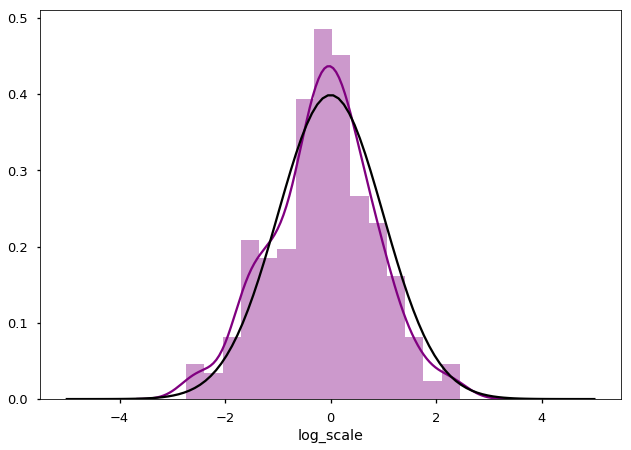

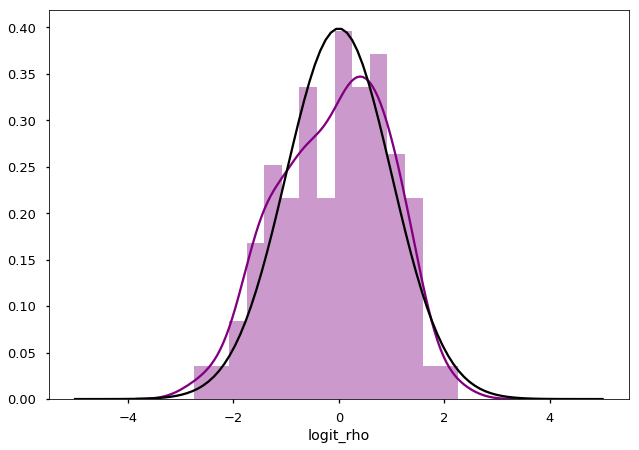

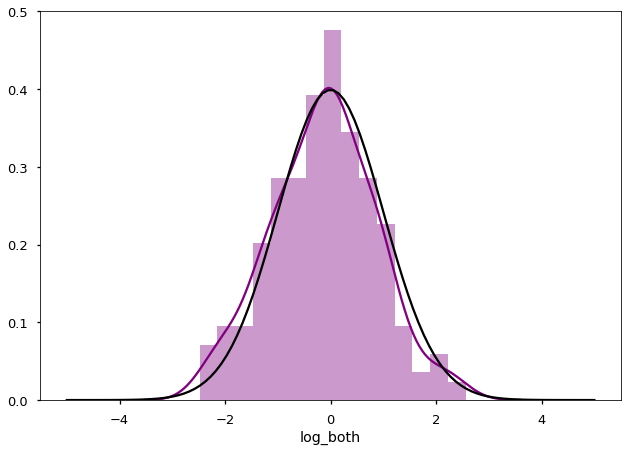

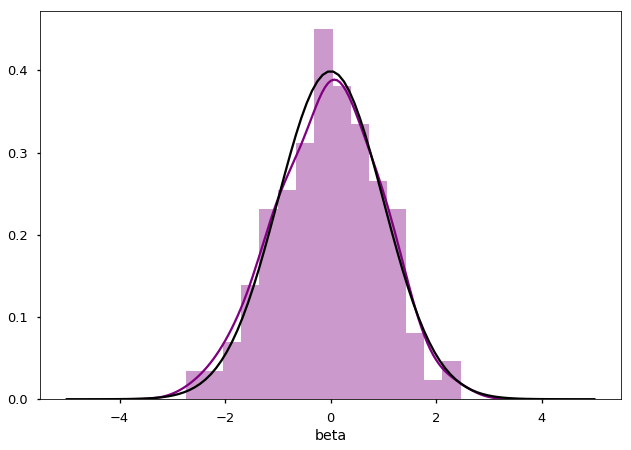

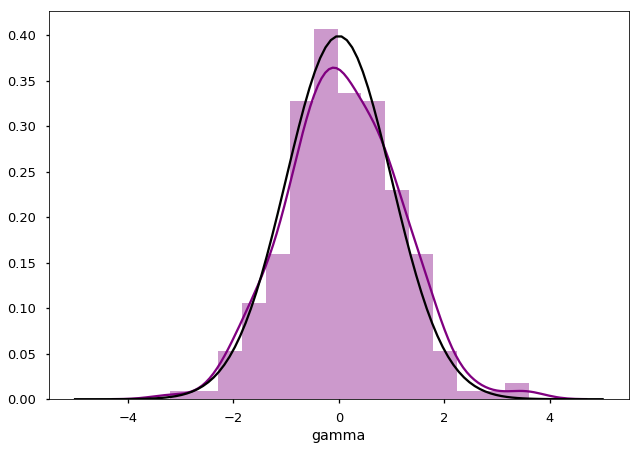

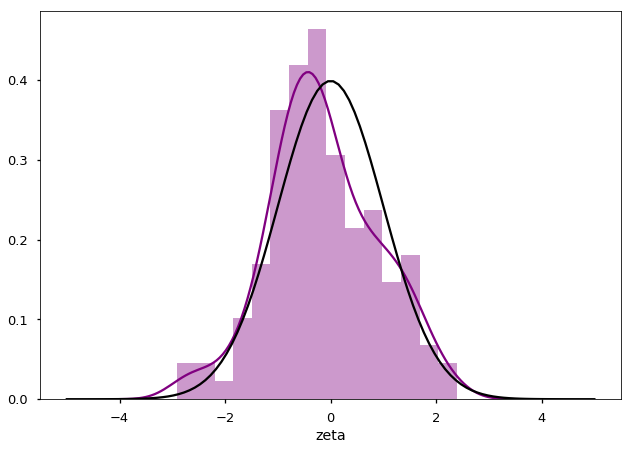

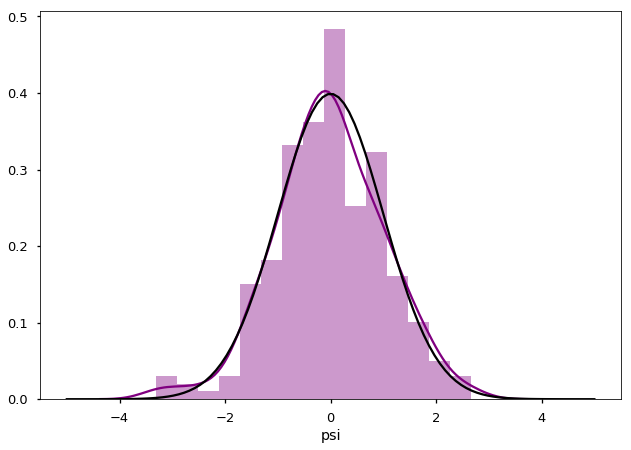

In [40]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in rf_names:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=15, color='purple')
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

In [41]:
def link_function_t_stats(est):
    params = est[0]
    st_params = total_true_params['phi'], total_true_params['pi'], total_true_params['theta']
    rf_names = ['beta', 'gamma', 'log_both', 'log_scale', 'logit_rho', 'psi', 'zeta']
    link = vl.link_total(*st_params, params['beta'], params['gamma'], params['log_both'], params['log_scale'],
                        params['logit_rho'], params['psi'], params['zeta'])
    cov_in = est[1].loc[rf_names, rf_names]
    
    cov = vl._covariance_kernel(*st_params, *st_params, params['log_both'], params['log_scale'],
                                params['logit_rho'],cov_in , params['psi'])
    
    return link /  np.diag(cov)**.5

In [42]:
link_t_stats = np.array([link_function_t_stats(est) for est in tqdm.tqdm_notebook(est_arr)])

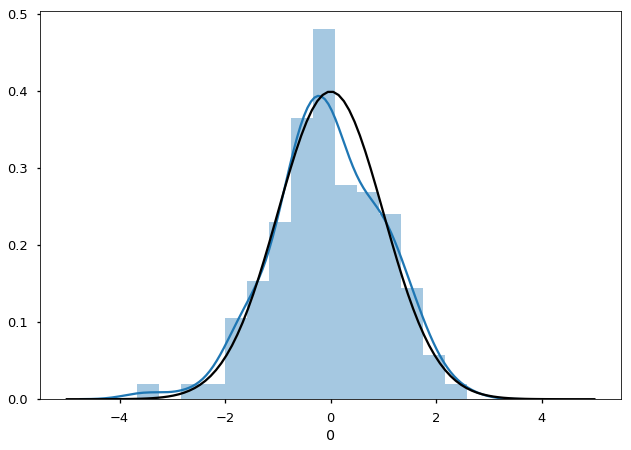

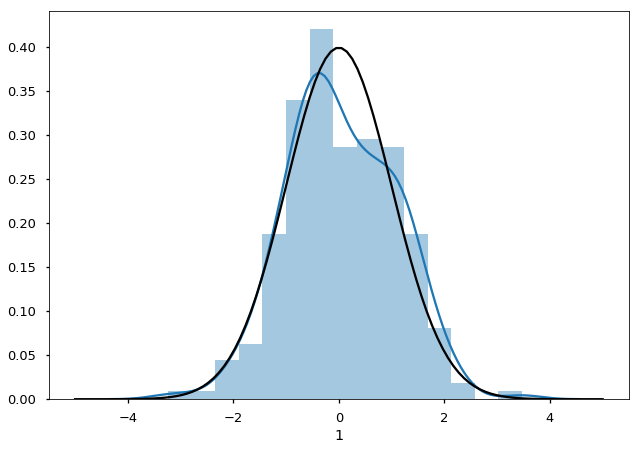

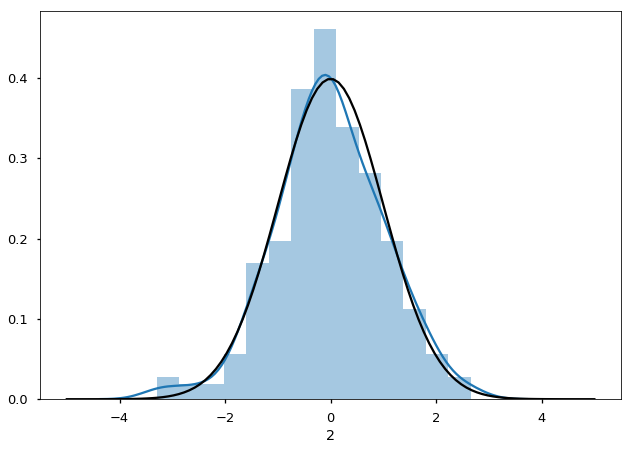

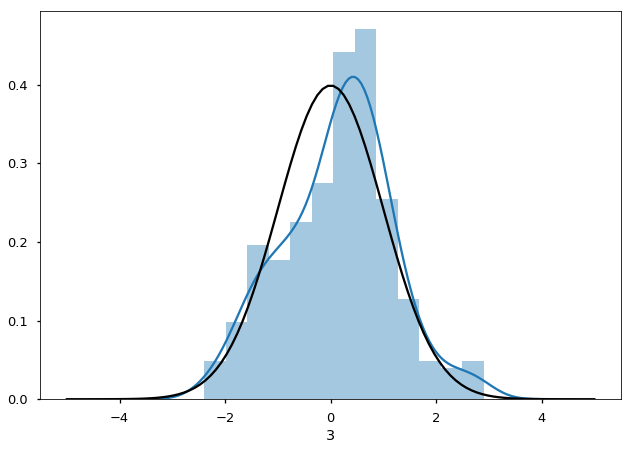

In [43]:
for key, col in enumerate(link_t_stats.T):
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(col, ax=ax)
    ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

    ax.set_xlabel(key)

In [44]:
bounds

{'pi': {'max': 0, 'min': -25, 'dim': 32},
 'phi': {'max': 0, 'min': -0.5, 'dim': 4},
 'theta': {'max': 2.5, 'min': 0, 'dim': 12}}

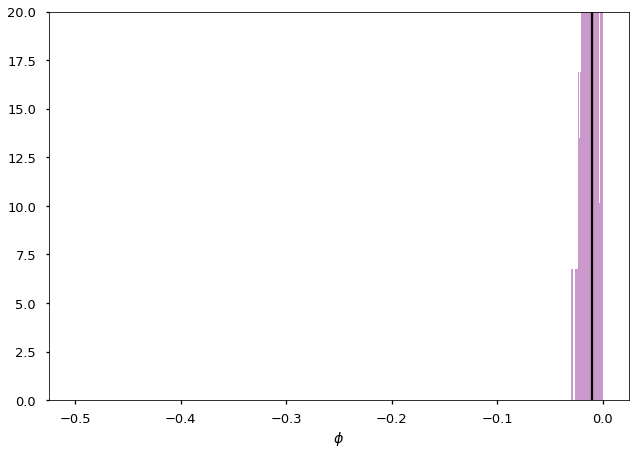

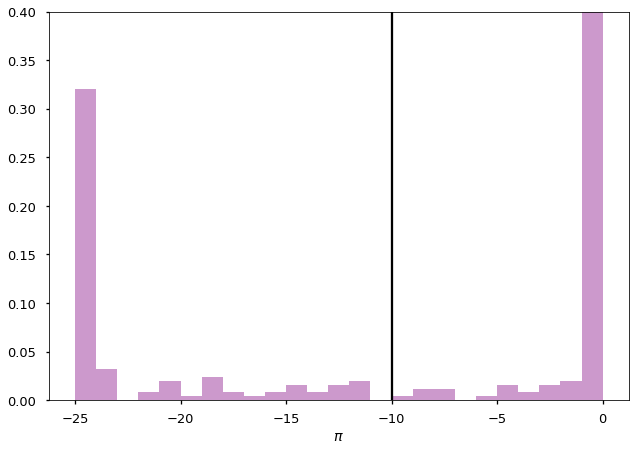

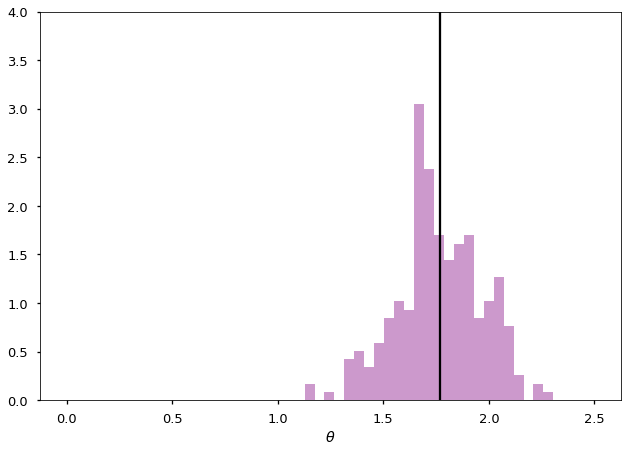

In [45]:
for name in ['phi', 'pi', 'theta']:
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(pd.Series([est[name] 
                                for est, cov in est_arr]).dropna(), ax=ax, color='purple', bins=25,
                     kde=False, norm_hist=True)
    diff = (bounds[name]['max'] - bounds[name]['min'])
    ax.set_xlim([bounds[name]['min'] - .05 * diff ,  bounds[name]['max'] + .05 * diff])

    ax.set_ylim([0, 10 / diff])
    ax.axvline(true_params[name], color='black')
        
    ax.set_xlabel(f"$\{name}$")

    fig.savefig(f"../doc/figures/{name}_est_{innov_dim}_" + "{:.2f}".format(true_params['phi']).replace(
        ".", "_point_").replace("-", "minus_") + ".tmp.pdf", frameon=False, pad_inches=0,
                bbox_inches='tight', transparent=True)

# I now compute the robust conditional QLR statistic 

In [46]:
omega

{'gamma': 0.0009014863664124776,
 'beta': 0.07192678228039884,
 'psi': 1.2768046680050529,
 'zeta': 1.0590414512328532,
 'log_both': -5.926239294053325,
 'log_scale': -5.558178821997083,
 'logit_rho': 1.3610382149874154}

In [47]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [48]:
def compute_ar(params):
    param_est, param_cov = params
    names = vl.compute_names()
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov)

In [49]:
param_est, param_cov = est_arr[0]
names = vl.compute_names()
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]

In [50]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

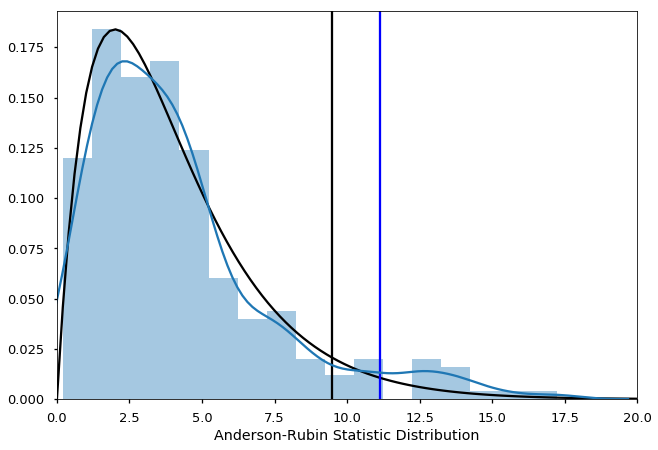

In [51]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')

    ax.set_xlabel('Anderson-Rubin Statistic Distribution')
    ax.set_xlim(0, 20)
    ax.axvline(stats.chi2.ppf(df=4, q=.95), color='black')
    ax.axvline(np.percentile(ar_results, 95), color='blue')

    sns.distplot(ar_results, ax=ax)
    

In [52]:
np.mean(ar_results >= stats.chi2.ppf(df=4, q=.95))

0    0.076
dtype: float64

In [53]:
# compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
#                                                            true_params['theta']],
#                       innov_dim=innov_dim, alpha=None, robust_quantile=True, bounds=bounds)

In [54]:
# compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
#                                                            true_params['theta']],
#                       innov_dim=100, alpha=None, robust_quantile=True, bounds=bounds)
# total=min(100, len(est_arr))
# with Pool(8) as pool:
#     results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
#                                                                                     est_arr[:total]),
#                                                           total=total))))

In [55]:
# fig, ax = mpl.pyplot.subplots()
# sns.distplot(np.ravel(results.iloc[:,1:]), ax=ax, color='green')
# sns.distplot(np.ravel(ar_results), ax=ax, color='red')
# sns.distplot(np.ravel(results.iloc[:,0]), ax=ax, color='purple')

In [56]:
# robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
#                                     reference_data=results.iloc[:,1:]).replace(np.inf, 1)
# standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)
# ar_pit = stats.chi2.cdf(ar_results, df=4)

In [57]:
# fig, ax = mpl.pyplot.subplots()
# cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='standard')
# cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='robust')
# cdpm.pit_plot(ar_pit, ax=ax, color='green', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='ar')
# ax.legend()
# fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
#             frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [58]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, 
                                        robust_quantile=True, bounds=bounds)

In [59]:
np.percentile(returnval.qlr_stat, 95)

5.915287089854761

In [60]:
true_params['phi']

-0.01

In [66]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], time_dim)
    
returnval.to_json(filename)

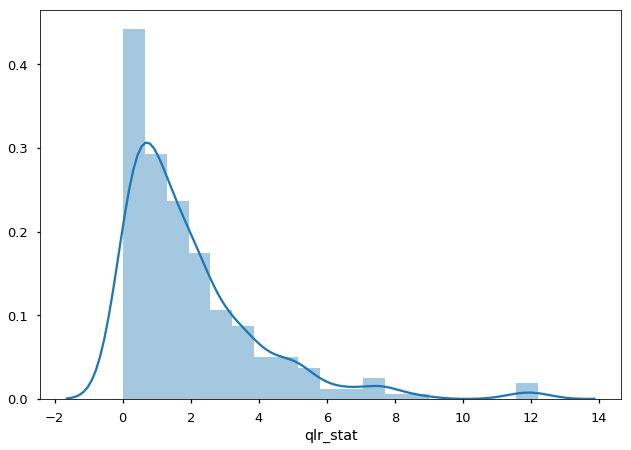

In [62]:
sns.distplot(returnval.qlr_stat)

In [63]:
returnval.query('robust_qlr_qauntile < 9.48').mean()

qlr_stat               2.004980
robust_qlr_qauntile    5.718041
robust                 0.052000
standard               0.020000
dtype: float64

In [64]:
returnval.mean()

qlr_stat               2.004980
robust_qlr_qauntile    5.718041
robust                 0.052000
standard               0.020000
dtype: float64

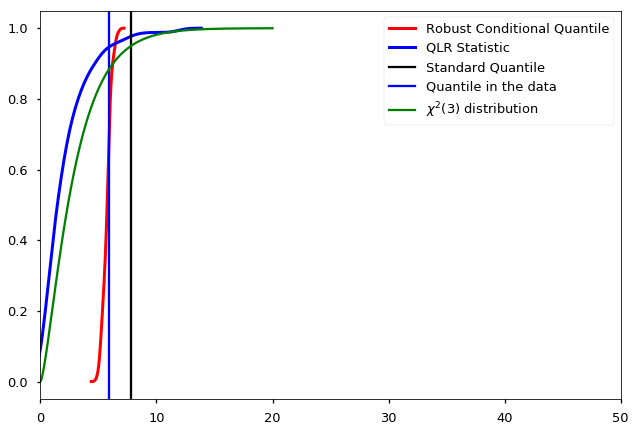

In [65]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)